# Предсказание данных **цены на недвижимости**

In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from models.pl_model import NeuralNetworkPL
from datasets.dataset import CustomDataset

### Подготовка данных

In [4]:
features_train = [] 
prices = []         

with open('../data/property_price/preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    featuresTitles = { key: [] for key in reader.fieldnames if key != 'SalePrice' }
    salePrices = []
    
    for row in reader:
        try:
            salePrice = float(row['SalePrice'])
            salePrices.append(salePrice)
            
            for feature in featuresTitles:
                featuresTitles[feature].append(float(row[feature]))
        except ValueError:
            continue

salePrices = np.array(salePrices)
featuresTitles = { key: np.array(values) for key, values in featuresTitles.items() }

correlations = {}
for feature, values in featuresTitles.items():
    valid_indices = ~np.isnan(values) 
    if np.any(valid_indices):
        correlation = np.corrcoef(values[valid_indices], salePrices[valid_indices])[0, 1]
        correlations[feature] = abs(correlation) 

best_feature = max(correlations, key=correlations.get)
print(f"Лучший признак: {best_feature} (корреляция: {correlations[best_feature]:.5f})")

with open('../data/property_price/preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row[best_feature] == 'NA' or row['SalePrice'] == 'NA':
            continue
        
        best_feature_value = float(row[best_feature])
        sale_price = float(row['SalePrice'])
        
        features_train.append([best_feature_value])
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices).reshape(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    features_train, prices, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_dataset = CustomDataset(X_train_scaled, y_train)
val_dataset = CustomDataset(X_val_scaled, y_val)
test_dataset = CustomDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=5, persistent_workers=True)

Лучший признак: OverallQual (корреляция: 0.81751)


### Обучение модели

In [5]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
model = NeuralNetworkPL(
    input_size=1,
    hidden_sizes=[100, 50],
    output_size=1,
    activation='relu',
    task='regression'
)

trainer = pl.Trainer(max_epochs=200, accelerator="auto", log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\University\NeuralNetworks\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 5.3 K  | train
--------------------------------------------
5.3 K     Trainab

Epoch 199: 100%|██████████| 27/27 [00:00<00:00, 145.38it/s, v_num=6]       

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 27/27 [00:00<00:00, 137.61it/s, v_num=6]


### Тестирование

In [6]:
trainer.test(model, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 265.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04947209358215332    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04947209358215332}]

### Визуализация

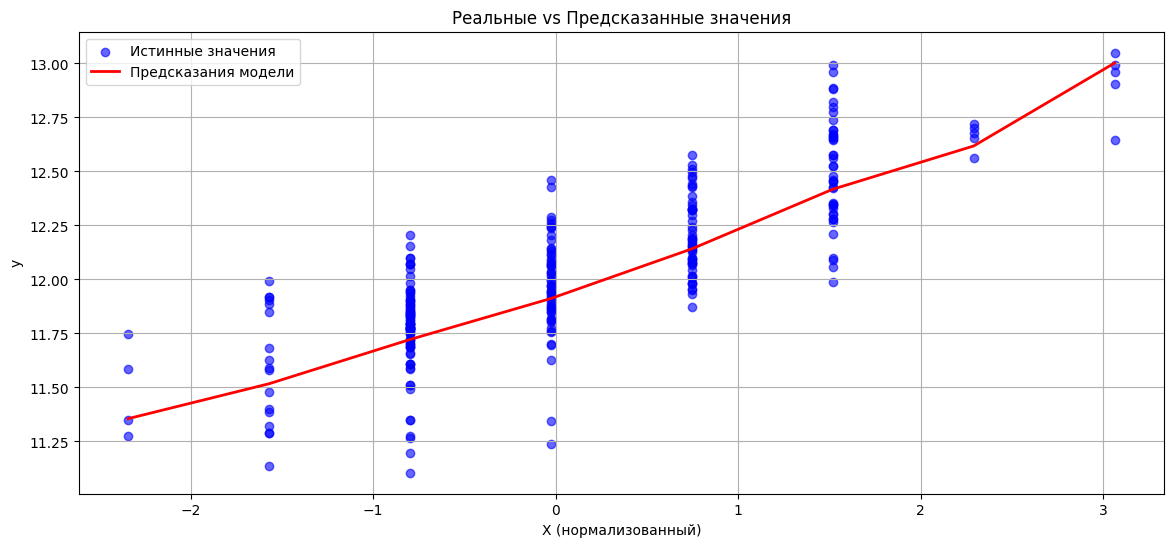

In [9]:
model.eval()
X_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_tensor).numpy()

sorted_indices = np.argsort(X_test_scaled[:, 0])
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled[sorted_indices].flatten(), y_test[sorted_indices].flatten(),
            label='Истинные значения', color='blue', alpha=0.6)
plt.plot(X_test_scaled[sorted_indices].flatten(), predictions[sorted_indices].flatten(),
         label='Предсказания модели', color='red', linewidth=2)
plt.title('Реальные vs Предсказанные значения')
plt.xlabel('X (нормализованный)')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()